In [1]:
!pip install numpy==1.23.0
!pip install tensorflow==2.12.0 tensorflow-estimator==2.12.0
!pip install tensorflow-privacy==0.8.0

  Using cached numpy-1.23.0-cp311-cp311-linux_x86_64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.30 requires numpy>=1.23.2; python_version >= "3.11", but you have numpy 1.23.0 which is incompatible.
tensorflow-privacy 0.9.0 requires tensorflow-probability~=0.22.0, but you have tensorflow-probability 0.20.1 which is incompatible.
pandas-stubs 2.2.2.240909 requires numpy>=1.23.5, but you have numpy 1.23.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.0 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
pandas 2.2.2 requires numpy>=1.23.2; python_version == "3.11", but you have numpy 1.23.0 wh

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.9.0 requires tensorflow-probability~=0.22.0, but you have tensorflow-probability 0.20.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4

  Using cached tensorflow_privacy-0.8.0-py3-none-any.whl.metadata (637 bytes)
  Using cached absl_py-1.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached attrs-21.2.0-py2.py3-none-any.whl.metadata (9.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-privacy to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy~=1.21.5 (from tensorflow-privacy) (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10

In [ ]:
# Removed git installation as it caused version conflicts
# !pip install git+https://github.com/tensorflow/privacy.git

In [2]:
!pip install tensorflow-probability==0.20.1

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
#import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import seaborn as sns

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Create mapping for gender column
gender_mapping = {'Male': 0, 'Female': 1, '--': 1}

# Apply mapping to create new column in both datasets
train['upd_gender'] = train['gender'].map(gender_mapping)
test['upd_gender'] = test['gender'].map(gender_mapping)

In [5]:
# Create mapping for howlong column with partial matching
def map_howlong(value):
    if '4+ years' in value:
        return 4
    elif '2-4 years' in value:
        return 3
    elif '1-2 years' in value:
        return 2
    elif '6-12 months' in value:
        return 1
    elif 'Less than 6 months' in value:
        return 0
    else:
        return None

# Apply mapping to create new column in both datasets
train['upd_howlong'] = train['howlong'].apply(map_howlong)
test['upd_howlong'] = test['howlong'].apply(map_howlong)

In [6]:
# Select only numeric columns for training
numeric_cols = ['age', 'upd_gender', 'height', 'weight', 'upd_howlong'] #leakage - 'candj', 'snatch', 'deadlift', 'backsq',
X_train, y_train = train[numeric_cols], train['total_lift']
X_test, y_test = test[numeric_cols], test['total_lift']

In [8]:

# Re-define and train the model without DP
model_original = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model with a standard optimizer
model_original.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Train the model on the original data
history_original = model_original.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test data
results_original = model_original.evaluate(X_test, y_test, verbose=0)
print(f'Original Model Test Loss (MSE): {results_original[0]:.4f}')
print(f'Original Model Test MAE: {results_original[1]:.4f}')
print(f'Original Model Test MSE: {results_original[2]:.4f}')

# Make predictions
y_pred_original = model_original.predict(X_test)

# Calculate additional metrics
mae_original = mean_absolute_error(y_test, y_pred_original)
rmse_original = root_mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print(f'Original Model MAE: {mae_original:.4f}')
print(f'Original Model RMSE: {rmse_original:.4f}')
print(f'Original Model R-squared: {r2_original:.4f}')

Epoch 1/5
601/601 [==============================] - 3s 3ms/step - loss: 132703.7969 - mae: 254.9806 - mse: 132703.7969 - val_loss: 47429.2031 - val_mae: 174.6687 - val_mse: 47429.2031
Epoch 2/5
601/601 [==============================] - 1s 2ms/step - loss: 43149.3359 - mae: 163.7101 - mse: 43149.3359 - val_loss: 40786.3438 - val_mae: 159.3618 - val_mse: 40786.3438
Epoch 3/5
601/601 [==============================] - 2s 3ms/step - loss: 38891.7656 - mae: 153.9100 - mse: 38891.7656 - val_loss: 37127.4180 - val_mae: 151.1976 - val_mse: 37127.4180
Epoch 4/5
601/601 [==============================] - 1s 2ms/step - loss: 35976.0234 - mae: 147.6867 - mse: 35976.0234 - val_loss: 34252.6875 - val_mae: 145.3016 - val_mse: 34252.6875
Epoch 5/5
601/601 [==============================] - 1s 2ms/step - loss: 33287.9961 - mae: 141.9081 - mse: 33287.9961 - val_loss: 31650.9434 - val_mae: 139.2443 - val_mse: 31650.9434
Original Model Test Loss (MSE): 31300.3027
Original Model Test MAE: 138.1643
Origin

In [9]:
# DP training params
learning_rate = 0.1
noise_multiplier = 1.15
l2_norm_clip = 1.0
batch_size = 64
epochs = 5
num_microbatches = batch_size

In [10]:
# Create datasets with drop_remainder=True to ensure batch size consistency
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(1)
])

# Use DP-SGD optimizer from tensorflow_privacy
optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

# Use per-example loss (no reduction)
loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse'])

In [12]:
# Train
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

Epoch 1/5
375/375 [==============================] - 5s 9ms/step - loss: 75573.7656 - mae: 200.0235 - mse: 75573.7656 - val_loss: 46523.8984 - val_mae: 170.2072 - val_mse: 46523.8984
Epoch 2/5
375/375 [==============================] - 3s 8ms/step - loss: 46483.5430 - mae: 169.6175 - mse: 46483.5430 - val_loss: 45691.7695 - val_mae: 167.9374 - val_mse: 45691.7695
Epoch 3/5
375/375 [==============================] - 3s 8ms/step - loss: 46055.2227 - mae: 167.7076 - mse: 46055.2227 - val_loss: 45111.7461 - val_mae: 166.0730 - val_mse: 45111.7461
Epoch 4/5
375/375 [==============================] - 5s 14ms/step - loss: 45723.8359 - mae: 166.2966 - mse: 45723.8359 - val_loss: 44893.5312 - val_mae: 165.0863 - val_mse: 44893.5312
Epoch 5/5
375/375 [==============================] - 3s 9ms/step - loss: 45564.5352 - mae: 165.1751 - mse: 45564.5352 - val_loss: 44633.4531 - val_mae: 164.0769 - val_mse: 44633.4531


In [13]:
# prompt: from train_dataset and test_dataset make X_test, y_test, X_train ...

# Separate features and target from the datasets
X_train = train_dataset.map(lambda x, y: x)
y_train = train_dataset.map(lambda x, y: y)

X_test = test_dataset.map(lambda x, y: x)
y_test = test_dataset.map(lambda x, y: y)

In [18]:
# CORRECTED EVALUATION AND PREDICTION FOR DP MODEL

# Evaluate the DP model directly on the test dataset
print("\n--- DP Model Evaluation ---")
results_dp = model.evaluate(test_dataset, verbose=0)
print(f'DP Model Test Loss (MSE): {results_dp[0]:.4f}')
print(f'DP Model Test MAE: {results_dp[1]:.4f}')

# Make predictions using the original X_test NumPy array
# First, get the data from the test_dataset
X_test_list = []
y_test_list = []
for batch_x, batch_y in test_dataset:
    X_test_list.append(batch_x.numpy())
    y_test_list.append(batch_y.numpy())

X_test_np = np.concatenate(X_test_list, axis=0)
y_test_np = np.concatenate(y_test_list, axis=0)

y_pred_dp = model.predict(X_test_np)

# Note: For a fair comparison, only use test samples that fit into a full batch,
# as drop_remainder=True was used during training.
# The data extracted from the dataset with drop_remainder=True already handles this.
y_test_batch_aligned = y_test_np
y_pred_dp_batch_aligned = y_pred_dp


mae_dp = mean_absolute_error(y_test_batch_aligned, y_pred_dp_batch_aligned)
rmse_dp = root_mean_squared_error(y_test_batch_aligned, y_pred_dp_batch_aligned)
r2_dp = r2_score(y_test_batch_aligned, y_pred_dp_batch_aligned)

print(f'DP Model MAE: {mae_dp:.4f}')
print(f'DP Model RMSE: {rmse_dp:.4f}')
print(f'DP Model R-squared: {r2_dp:.4f}')


# --- Privacy Calculation ---
# Use the variables defined earlier for consistency
# You need the original number of training examples for delta
# Assuming X_train still holds the original DataFrame before being turned into a dataset
num_train_examples = len(train)
delta = 1 / num_train_examples

epsilon, _ = compute_dp_sgd_privacy(
    n=num_train_examples,
    batch_size=batch_size, # Use variable from DP training section
    noise_multiplier=noise_multiplier, # Use variable
    epochs=epochs, # Use variable
    delta=delta
)

print(f"\nPrivacy Guarantee: Epsilon = {epsilon:.3f} for Delta = {delta}")


--- DP Model Evaluation ---
DP Model Test Loss (MSE): 44633.4531
DP Model Test MAE: 164.0769
186/186 [==============================] - 1s 5ms/step


DP Model MAE: 164.0769
DP Model RMSE: 211.2663
DP Model R-squared: 0.4186

Privacy Guarantee: Epsilon = 0.589 for Delta = 4.1626774341256295e-05


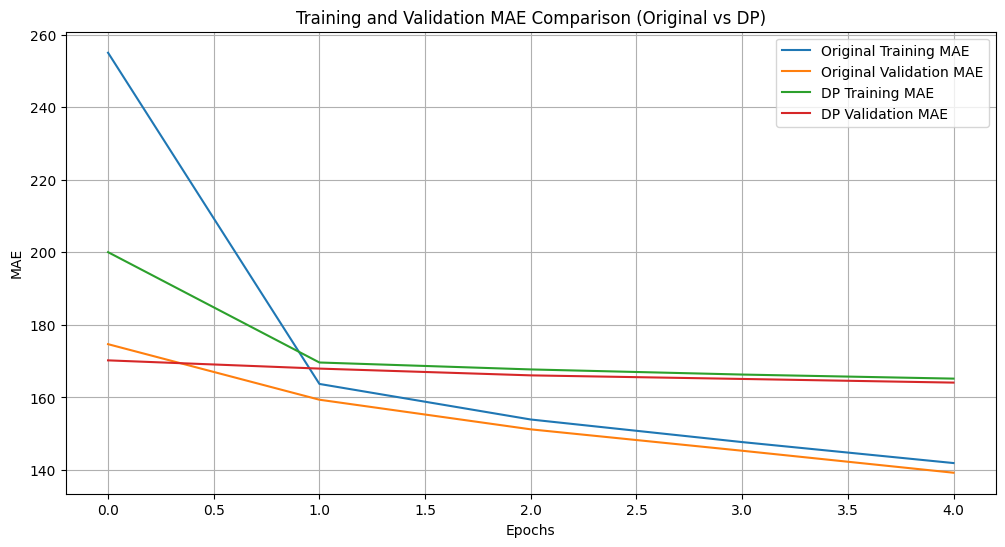

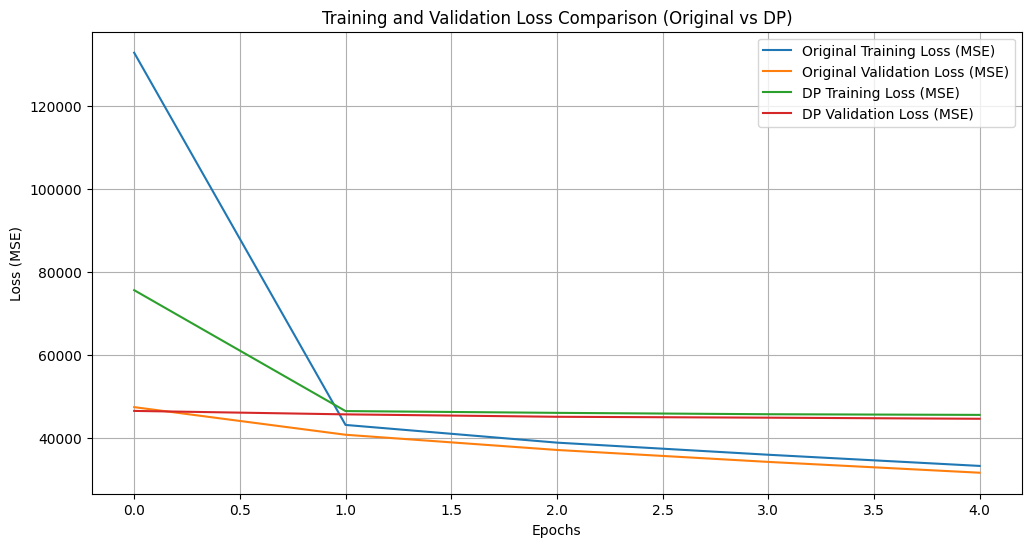

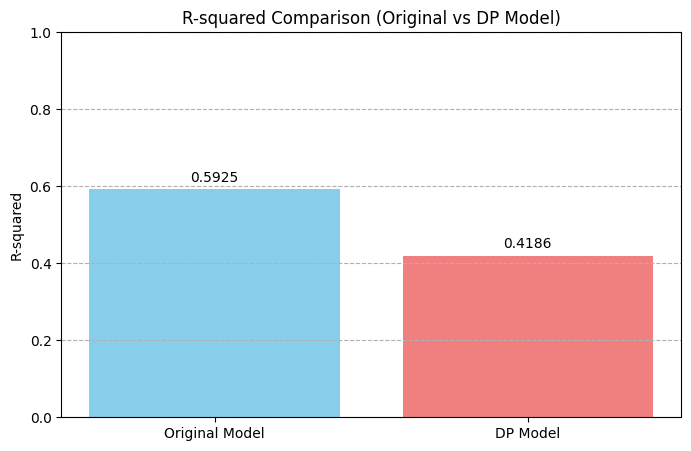

<Figure size 1000x600 with 0 Axes>

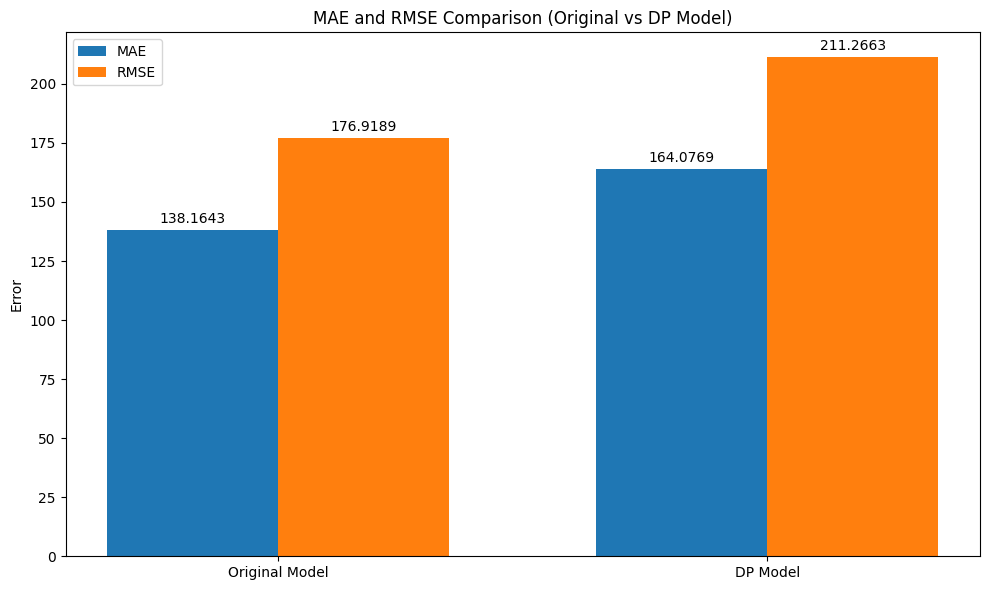

In [25]:
# prompt: create plots to compare original and DP model performaces, r2 in a different graph

import numpy as np
import matplotlib.pyplot as plt

# Extract metrics for plotting
original_mae = history_original.history['val_mae']
dp_mae = history.history['val_mae']
original_loss = history_original.history['val_loss']
dp_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot MAE
plt.figure(figsize=(12, 6))
plt.plot(history_original.history['mae'], label='Original Training MAE')
plt.plot(original_mae, label='Original Validation MAE')
plt.plot(history.history['mae'], label='DP Training MAE')
plt.plot(dp_mae, label='DP Validation MAE')
plt.title('Training and Validation MAE Comparison (Original vs DP)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss (MSE)
plt.figure(figsize=(12, 6))
plt.plot(history_original.history['loss'], label='Original Training Loss (MSE)')
plt.plot(original_loss, label='Original Validation Loss (MSE)')
plt.plot(history.history['loss'], label='DP Training Loss (MSE)')
plt.plot(dp_loss, label='DP Validation Loss (MSE)')
plt.title('Training and Validation Loss Comparison (Original vs DP)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Plot R2 Score
plt.figure(figsize=(8, 5))
metrics_labels = ['Original Model', 'DP Model']
r2_scores = [r2_original, r2_dp]

plt.bar(metrics_labels, r2_scores, color=['skyblue', 'lightcoral'])
plt.ylabel('R-squared')
plt.title('R-squared Comparison (Original vs DP Model)')
plt.ylim(0, 1) # R-squared is typically between 0 and 1 for regression, though it can be negative
plt.grid(axis='y', linestyle='--')

# Add values on top of bars
for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center')

plt.show()

# Optional: Plot MAE and RMSE from final test evaluation
plt.figure(figsize=(10, 6))
metrics_labels = ['Original Model', 'DP Model']
mae_scores = [mae_original, mae_dp]
rmse_scores = [rmse_original, rmse_dp]

x = np.arange(len(metrics_labels)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE')
rects2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error')
ax.set_title('MAE and RMSE Comparison (Original vs DP Model)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()